<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/MODWT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyWavelets

In [2]:
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [3]:
import numpy as np
import pdb
import pywt


def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2 ** (j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2 ** (j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra(h_j_o, w_j):
    ''' calculate the mra D_j'''
    N = len(w_j)
    l = np.arange(N)
    D_j = np.zeros(N)
    for t in range(N):
        index = np.mod(t + l, N)
        w_j_p = np.array([w_j[ind] for ind in index])
        D_j[t] = (np.array(h_j_o) * w_j_p).sum()
    return D_j


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2 ** ((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2 ** ((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)


if __name__ == '__main__':
    s1 = np.arange(10)
    ws = modwt(s1, 'db2', 3)
    s1p = imodwt(ws, 'db2')
    mra = modwtmra(ws, 'db2')

In [4]:
import numpy as np
import pdb
import pywt
import pdb



In [ ]:
import numpy as np
data = np.genfromtxt("BE_price.csv", delimiter = ","); data = np.asarray(data); data.shape

In [7]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(52416,)

In [8]:
scaled_data = np.transpose(scaled_data)

In [9]:
scaled_data = scaled_data.reshape(-1,1)


In [10]:
#from modwt import modwt, modwtmra
import pandas as pd
wt = modwt(scaled_data, 'db2', 8)
wtmra = modwtmra(wt, 'db2')

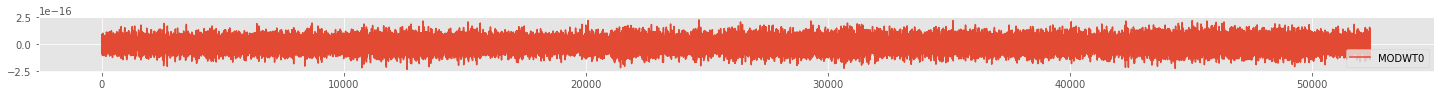

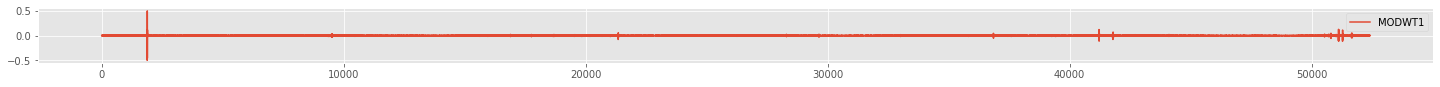

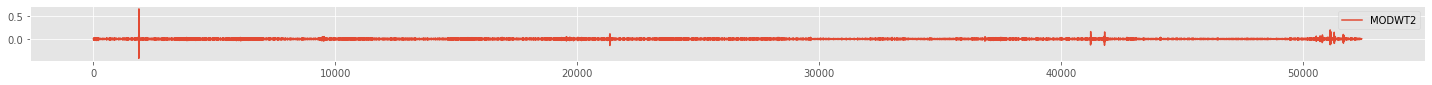

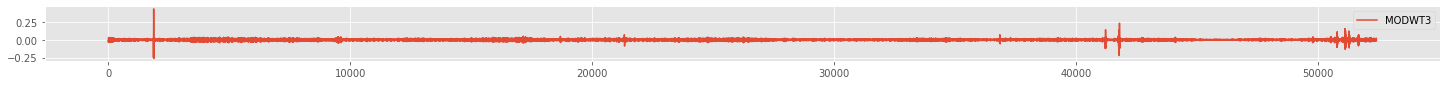

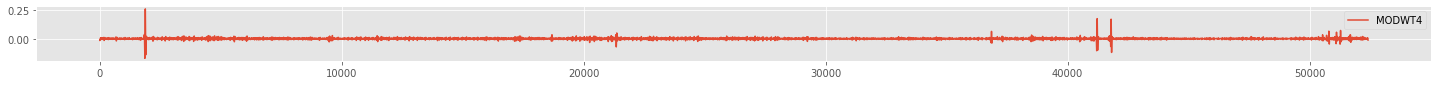

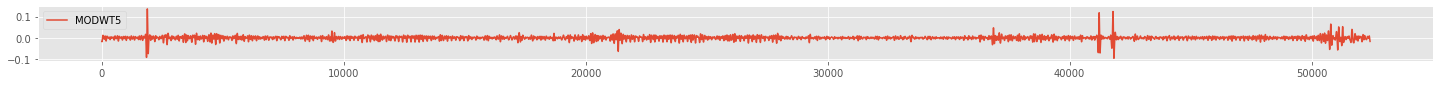

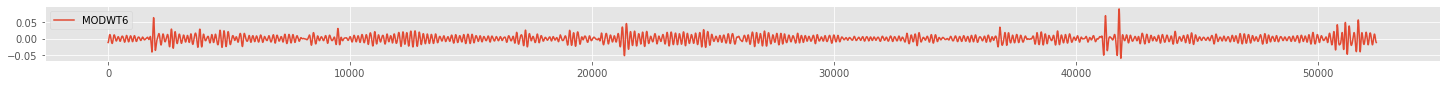

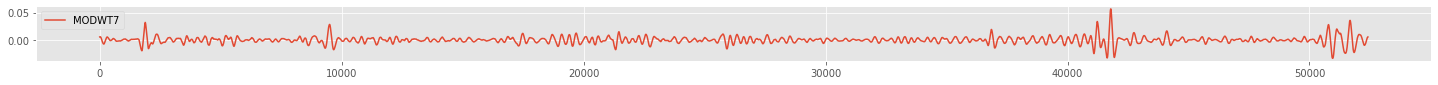

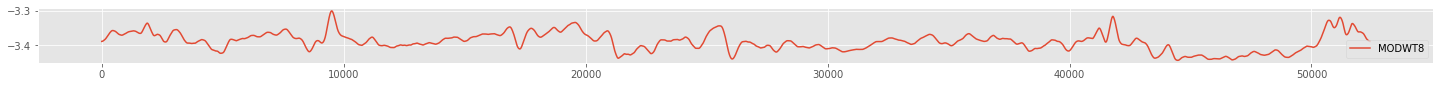

In [11]:
for i in range(len(wtmra)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(wtmra[i], label = "MODWT{}".format(i))
  plt.legend()
  plt.show()

In [12]:
# Save decomposition data
from pandas import DataFrame
import pandas as pd
import csv
Be_price_MODWT=pd.DataFrame(wtmra).T

# Save as csv
Be_price_MODWT.to_csv("Be_price_MODWT.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')

# Save as excel
Be_price_MODWT.to_excel("Be_price_MODWT.xlsx", header=True)

print(Be_price_MODWT)


                  0         1         2  ...         6         7         8
0     -2.403703e-17  0.001629  0.002904  ... -0.011562  0.005607 -3.388352
1     -1.895741e-17 -0.001080 -0.001678  ... -0.011527  0.005631 -3.388355
2     -3.081488e-33 -0.002116 -0.007168  ... -0.011462  0.005654 -3.388357
3     -3.081488e-33 -0.000342 -0.012673  ... -0.011366  0.005678 -3.388357
4      1.015925e-17  0.001064 -0.016742  ... -0.011240  0.005702 -3.388356
...             ...       ...       ...  ...       ...       ...       ...
52411 -2.911666e-17 -0.002939  0.002339  ... -0.011341  0.005476 -3.388316
52412 -3.791482e-17 -0.003345  0.003180  ... -0.011434  0.005505 -3.388326
52413  1.523887e-17  0.000107  0.004761  ... -0.011504  0.005533 -3.388334
52414  6.195185e-17  0.003200  0.005785  ... -0.011550  0.005559 -3.388341
52415  1.387779e-17  0.003478  0.005354  ... -0.011569  0.005584 -3.388347

[52416 rows x 9 columns]
